# Visualise Dopamine D4 receptor docking dataset

## Imports

In [8]:
import pandas as pd
from math import log, floor


def human_bytes(n_bytes):
    """Given n_bytes as a float, returns a string describing the byte size in human-readable form
    
    As an example, human_bytes(1536) = 1.5KB

    Args:
        n_bytes (float): The bytesize that you wish to read.

    Returns:
        byte_string (string): Human-readable string of the byte size.
    """
    units = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
    k = 1024.0
    magnitude = int(floor(log(n_bytes, k)))
    byte_string = '%.2f%s' % (n_bytes / k**magnitude, units[magnitude])
    return byte_string


def human_len(list_like):
    """Given a list like, returns the length of the object in human-readable form

    As an example, human_bytes(12500) = 12.5K

    Args:
        list_like: An object with the __len__ method.

    Returns:
        length_string (string): Human-readable string of the object size.
    """
    number = len(list_like)
    units = ['', 'K', 'M', 'G', 'T', 'P']
    k = 1000.0
    magnitude = int(floor(log(number, k)))
    length_string = '%.2f%s' % (number / k**magnitude, units[magnitude])
    return length_string


## Load Data 

just loading dockscore to keep memory low!

In [9]:
df = pd.read_csv('../datasets/D4_screen_table.csv',
                 usecols=['smiles', 'dockscore'])

print(f'Length of dataset: {human_len(df)}')
df = df.query('dockscore != "no_score"').dropna().set_index("smiles")
print(f'Length of dataset with valid dockscores: {human_len(df)}')
print(
    f'Memory used by dataframe: {human_bytes(df.memory_usage(deep=True).sum())}')

# Save to pickle for fast loading later on
df.to_pickle('../datasets/D4_docked_valid.pkl')


Length of dataset: 138.31M
Length of dataset with valid dockscores: 116.24M
Memory used by dataframe: 11.61GB


## Plot Dockscore

AttributeError: 'FacetGrid' object has no attribute 'show'

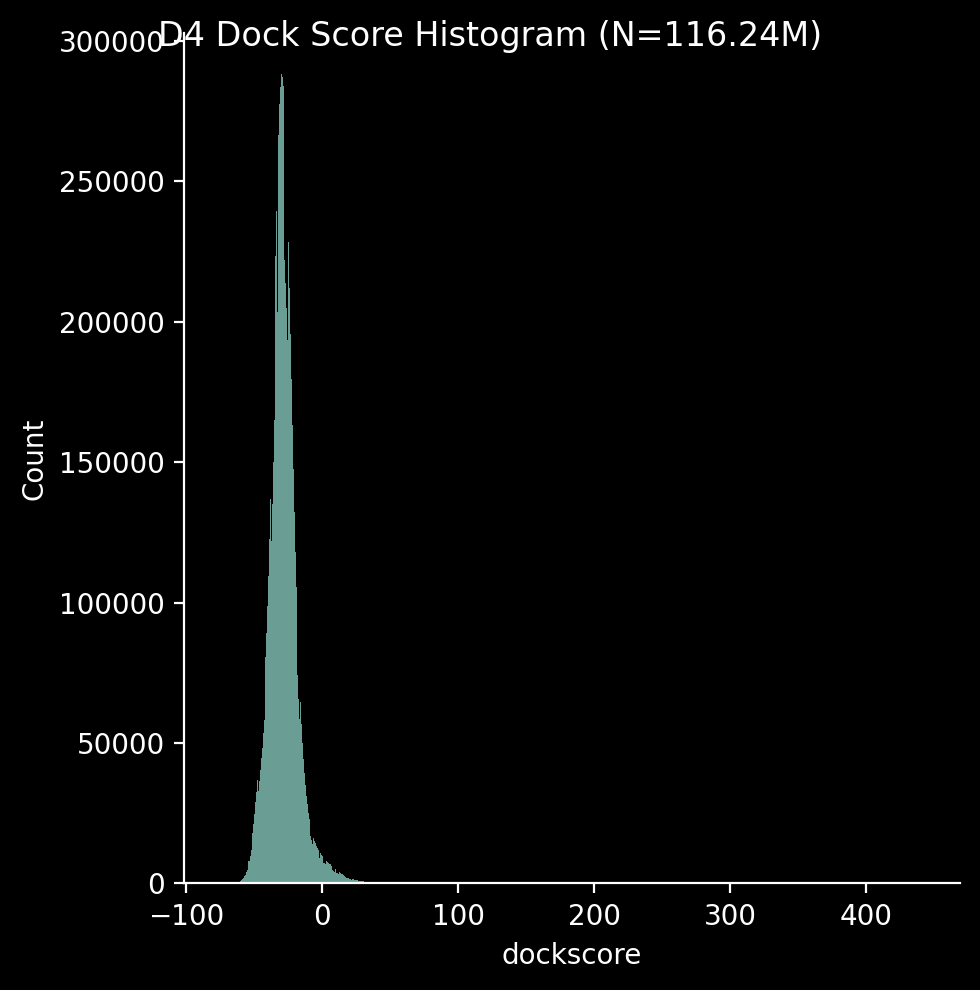

In [5]:
import seaborn as sns
from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

plt = sns.displot(df.dockscore)
plt.fig.suptitle(f'D4 Dock Score Histogram (N={human_len(df)})')

## Dummy Check

How good is a model that just predicts the mean for everything?

In [6]:
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y = df['dockscore'].astype(float).values
noise = np.random.normal(0, 1, len(y))
mean_model = np.mean(y)*np.ones_like(y)+noise

print(f'Mean model predicts constant value {np.mean(y):.3f} + added random noise from N(0,1)')
print(f'MSE of mean model: {mean_squared_error(y, mean_model):.3f}')
print(f'R2 score of mean model: {r2_score(y, mean_model):.3f}')
print(f'Spearman rho of mean model: {spearmanr(y, mean_model)[0]:.3f}')

Mean model predicts constant value -28.46202165387439 + added random noise from N(0,1)
MSE of mean model: 121.020
R2 score of mean model: -0.008
Spearman rho of mean model: -0.000


In [5]:
import pandas as pd
from tqdm import tqdm
from rdkit import Chem

df = pd.read_csv('docked/ugis-00000000.can', delim_whitespace=True, 
                 header=None, names=['smiles','name','dock_score'], usecols=[0,2])

def remove_chirality(row):
    mol = Chem.MolFromSmiles(row['smiles'])
    Chem.RemoveStereochemistry(mol)
    row['smiles'] = Chem.MolToSmiles(mol)
    return row

tqdm.pandas()
df = df.progress_apply(remove_chirality, axis=1)
df.to_csv('docked/ugis-00000000.smi', index=False)

100%|██████████| 6954/6954 [00:04<00:00, 1468.45it/s]
